In [21]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 3.5 MB/s  0:00:08 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [catboost]1/2 [catboost]


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, CatBoostClassifier

In [23]:
df = pd.read_csv("timeline_with_coeffs.csv")

In [24]:
df.head()
df.columns

Index(['year', 'month', 'era', 'key_event', 'category', 'mental_state',
       'intensity', 'source', 'track_theme', '_themes_list',
       'matched_tracks_n', 'matched_track_titles', 'track_emo_score_list',
       'track_emo_score_mean', 'track_emo_score_median',
       'track_emo_score_v2_list', 'track_emo_score_v2_mean',
       'track_emo_score_v2_median', 'matched_themes'],
      dtype='object')

In [25]:
target = "track_emo_score_v2_mean"

In [26]:
mean = df[target].mean()
std = df[target].std()

threshold = mean + 1.5 * std # задаем порог, выше которого считаем значение пиком
df["is_peak"] = (df[target] > threshold).astype(int) # отмечаем пики как 1, остальные как 0

df["is_peak"].value_counts() # смотрим, сколько всего пиков и непиков

is_peak
0    256
1     13
Name: count, dtype: int64

In [27]:
LAGS = [1, 2, 3, 5, 6, 12] # задаем список лагов, которые будем использовать как признаки

for lag in LAGS:
    df[f"lag_{lag}"] = df[target].shift(lag) # добавляем значение коэффициента с прошлых периодов

df["roll_mean_3"] = df[target].rolling(3).mean() # считаем скользящее среднее за 3 месяца
df["roll_std_3"]  = df[target].rolling(3).std()  # считаем скользящее стандартное отклонение за 3 месяца

df["roll_mean_6"] = df[target].rolling(6).mean() # считаем скользящее среднее за 6 месяцев
df["roll_std_6"]  = df[target].rolling(6).std() # считаем скользящее стандартное отклонение за 6 месяцев

df["diff_1"] = df[target].diff() # считаем разницу между текущим и предыдущим значением

In [28]:
df_model = df.dropna().copy() # убираем строки с пропусками чтобы модель обучалась корректно

In [29]:
split = int(len(df_model) * 0.8) # берем 80% данных для обучения

train = df_model.iloc[:split] # обучающая выборка
test  = df_model.iloc[split:] # тестовая выборка

In [30]:
feature_cols = [              # формируем список признаков для модели
    col for col in df_model.columns
    if col.startswith("lag_")     # берем все лаговые признаки
    or col.startswith("roll_")       # берем все скользящие статистики
    or col == "diff_1"           # добавляем первую разность
]

X_train = train[feature_cols] # признаки для обучения модели
y_train = train[target] # целевая переменная для обучения

X_test = test[feature_cols] # признаки для тестовой выборки
y_test = test[target] # целевая переменная для теста

reg_model = CatBoostRegressor(  # создаем модель catboost для регрессии
    iterations=500,         # количество деревьев
    learning_rate=0.05,         # скорость обучения
    depth=6,              # глубина деревьев
    loss_function="RMSE",       # функция ошибки
    verbose=False           # отключаем вывод логов
)

reg_model.fit(X_train, y_train) # обучаем модель на тренировочных данных

y_base_pred = reg_model.predict(X_test) # получаем базовый прогноз модели

In [31]:
clf_model = CatBoostClassifier(   # создаем модель catboost для классификации пиков
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    verbose=False
)

clf_model.fit(X_train, train["is_peak"]) # обучаем модель определять пики по признакам

p_peak = clf_model.predict_proba(X_test)[:, 1] # получаем вероятность того, что точка является пиком

In [32]:
peak_amplitude = (                               # считаем среднюю силу пика
    df_model.loc[df_model["is_peak"] == 1, target].mean() # среднее значение в пиковых точках
    - df_model.loc[df_model["is_peak"] == 0, target].mean() # минус среднее значение в обычных точках
)

y_final_pred = y_base_pred + p_peak * peak_amplitude # усиливаем базовый прогноз с учетом вероятности пика

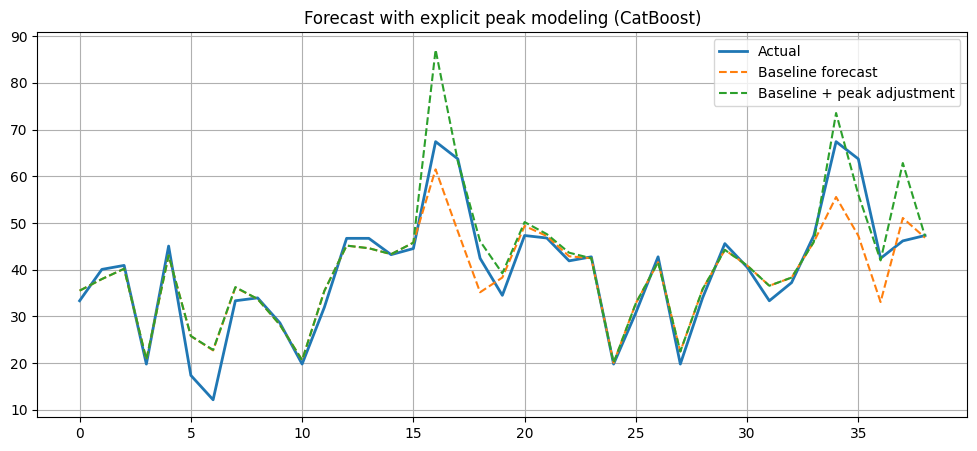

In [33]:
plt.figure(figsize=(12, 5))

plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_base_pred, label="Baseline forecast", linestyle="--")
plt.plot(y_final_pred, label="Baseline + peak adjustment", linestyle="--")

plt.legend()
plt.title("Forecast with explicit peak modeling (CatBoost)")
plt.grid(True)
plt.show()

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

target = "track_emo_score_v2_mean" # наша целевая переменная

FEATURES = [
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_6', 'lag_12',  # лаговые признаки
    'roll_mean_3', 'roll_std_3',                  # скользящие статистики за 3 месяца
    'roll_mean_6', 'roll_std_6',      # скользящие статистики за 6 месяцев
    'diff_1', 'delta_3',          # разности значений
    'year', 'month'          # календарные признаки
]

history = df_model.copy() # создаем копию данных для итеративного прогноза

last_date = pd.Timestamp(      # определяем последнюю дату в исходных данных
    year=int(history.iloc[-1]["year"]),
    month=int(history.iloc[-1]["month"]),
    day=1
)

end_date = pd.Timestamp(year=2028, month=12, day=1)  # задаем конечную дату прогноза
HORIZON = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)  # считаем количество месяцев для прогноза

In [35]:
future_preds = []
future_dates = []

for step in range(HORIZON): # цикл по всем шагам прогноза
    next_date = last_date + pd.DateOffset(months=1) # берем следующую дату
    future_dates.append(next_date) # сохраняем дату прогноза

    row = {} # словарь для признаков одного шага

    for lag in [1, 2, 3, 5, 6, 12]: # проходим по всем лагам
        row[f"lag_{lag}"] = history[target].iloc[-lag]  # берем прошлые значения ряда

    row["roll_mean_3"] = history[target].iloc[-3:].mean()
    row["roll_std_3"]  = history[target].iloc[-3:].std()

    row["roll_mean_6"] = history[target].iloc[-6:].mean()
    row["roll_std_6"]  = history[target].iloc[-6:].std()

    row["diff_1"] = history[target].iloc[-1] - history[target].iloc[-2] # разница с предыдущим месяцем
    row["delta_3"] = history[target].iloc[-1] - history[target].iloc[-4] # разница с тремя месяцами назад

    row["year"] = next_date.year # добавляем год как признак
    row["month"] = next_date.month # добавляем месяц как признак

    X_step = pd.DataFrame([row])[FEATURES] # формируем датафрейм признаков для модели

    base_pred = reg_model.predict(X_step)[0]  # получаем базовый прогноз регрессионной модели
    peak_prob = clf_model.predict_proba(X_step)[0, 1]  # считаем вероятность пика
    final_pred = base_pred + peak_prob * peak_amplitude  # усиливаем прогноз с учетом пиков

    future_preds.append(final_pred) # сохраняем итоговый прогноз

    new_row = history.iloc[-1].copy() # берем последнюю строку истории
    new_row[target] = final_pred # подставляем прогнозное значение
    new_row["year"] = next_date.year # обновляем год
    new_row["month"] = next_date.month # обновляем месяц

    history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True) # добавляем прогноз в историю
    last_date = next_date # обновляем последнюю дату

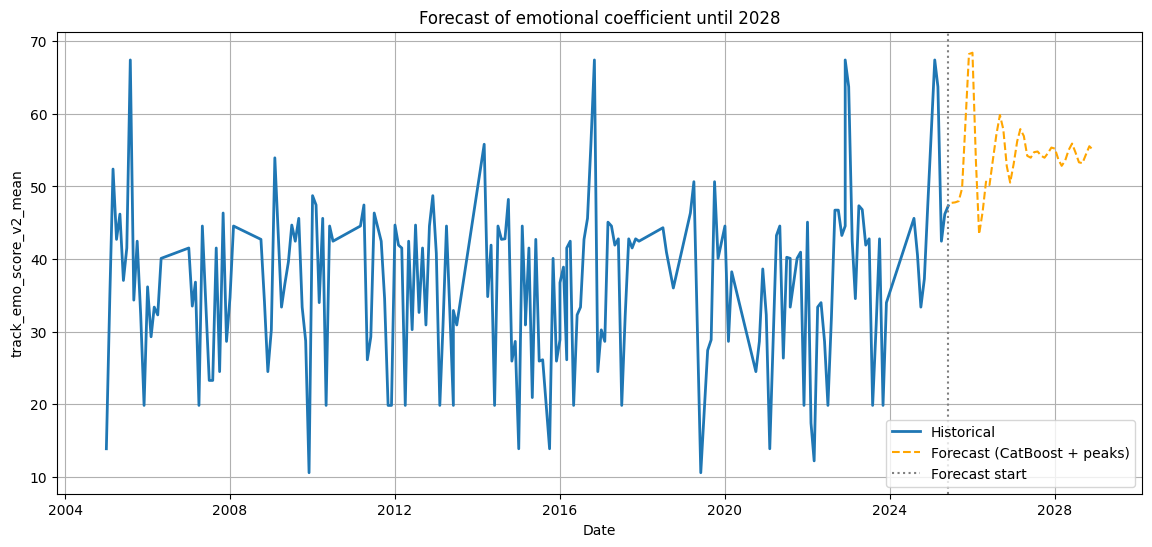

In [36]:
plt.figure(figsize=(14, 6))

hist_dates = pd.to_datetime(                # формируем даты для исторических данных
    dict(year=df_model["year"], month=df_model["month"], day=1)
)
plt.plot(hist_dates, df_model[target], label="Historical", linewidth=2)

plt.plot(future_dates, future_preds, linestyle="--", color="orange",
         label="Forecast (CatBoost + peaks)")

plt.axvline(hist_dates.iloc[-1], color="gray", linestyle=":", label="Forecast start") # отмечаем начало прогноза

plt.title("Forecast of emotional coefficient until 2028")
plt.xlabel("Date")
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.show()